In [15]:
include("normNTK.jl")
using CairoMakie


In [16]:
N1 = 10000
model = Chain(Dense(1,N1,sigmoid),Dense(N1,1))|>f64

Chain(
  Dense(1 => 10000, σ),                 # 20_000 parameters
  Dense(10000 => 1),                    # 10_001 parameters
)                   # Total: 4 arrays, 30_001 parameters, 234.633 KiB.

In [17]:
Nx=21
xa=-1.0
xb=1.0
xVec=range(-1.0,stop=1.0,length=Nx);
xVec = hcat(xVec...)
yVec=xVec+0.01*randn(size(xVec));
yVec = hcat(yVec...)


1×21 Matrix{Float64}:
 -0.997433  -0.901305  -0.805741  -0.69773  …  0.786438  0.872428  0.99901

In [18]:
yHat=model(xVec)
# display(xVec)

1×21 Matrix{Float64}:
 0.310701  0.310794  0.310887  0.310981  …  0.31238  0.312473  0.312566

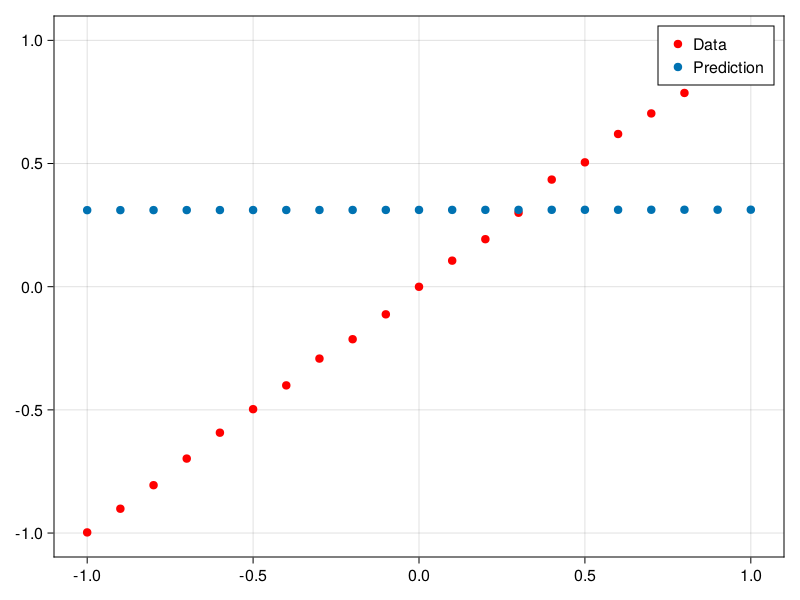

In [19]:
fig = Figure()
ax1 = Axis(fig[1,1])
s1 = CairoMakie.scatter!(ax1,xVec[:],yVec[:],color=:red,label="Data")
s2 = CairoMakie.scatter!(ax1,xVec[:],model(xVec)[:],label="Prediction")
axislegend(ax1,position=:rt)
fig


In [20]:
Loss(model,x,y) = Flux.mse(y,model(x));
loss = Loss(model,xVec,yVec)
display(loss)

train_data = [(xVec,yVec)]
opt = Descent(0.01)
N = 50
for i=1:N
    Flux.train!(Loss,model,train_data,opt)
end
loss_updt = Loss(model,xVec,yVec)

0.46207882868552214

41964.36522031069

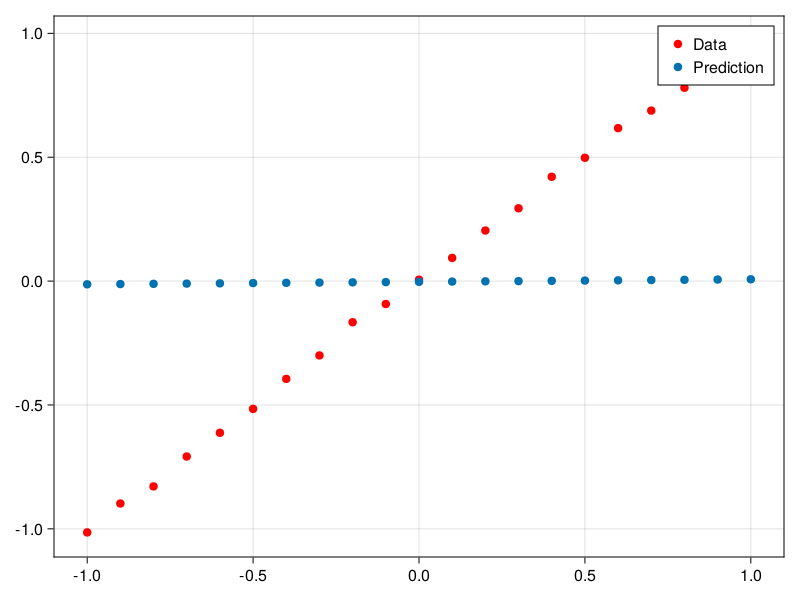

In [10]:
fig = Figure()
ax1 = Axis(fig[1,1])
s1 = CairoMakie.scatter!(ax1,xVec[:],yVec[:],color=:red,label="Data")
s2 = CairoMakie.scatter!(ax1,xVec[:],model(xVec)[:],label="Prediction")
axislegend(ax1,position=:rt)
fig

In [21]:
norm_params(model)

K = kernel(model,xVec)





21×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [ ]:
using Flux, LinearAlgebra, IterTools

function check_dim(x)
    if isa(x, Matrix)
        return size(x, 2)
    elseif isa(x, Vector)
        return 1
    else
        type = typeof(x)
        error("Input data type: $type is neither a matrix or column vector")
    end
end

function node_count(model)
    param(x)  = Flux.params(model)[x]
    n = []
    for i = 1:length(Flux.params(model))
        if i%2 != 0
            ni = size(param(i))[2]
            push!(n,ni)                 
        end                             
    end
    push!(n, length(param(length(Flux.params(model)))))
    return n
end

function norm_data(x)
    min_val = minimum(x)
    max_val = maximum(x)
    normalized_data = (2 * (x.-min_val) /(max_val - min_val)) .- 1
    
    return normalized_data
end

function norm_params(model)
    θ(x)  = Flux.params(model)[x]
    nNodes = node_count(model)

    i = 1
    for n = 1:length(nNodes)-1
        ni = nNodes[n]

        θ(i) .= θ(i) * 1/sqrt(ni)
        i += 1
        θ(i) .= θ(i) * 1/sqrt(ni)
        i += 1

    end
end

function map_model(model, X)
    N = check_dim(X)
    m = length(model(X[:,1]))  
    
    Ŷ = []

    if N == 1
        if m == 1
            push!(Ŷ, model((X[:, 1]))[1])  
        else
            push!(Ŷ, model((X[:, 1]))[:])  
        end
    else
        if m == 1
            for i in 1:N
                push!(Ŷ, model(X[:, i])[1])  
            end 
        else
            for i in 1:N
                push!(Ŷ, model(X[:, i])[:])  
            end 
        end
    end

    return Float64.(Ŷ)
end

function Df(model, x)
    all_params = Flux.params(model)  

    params_list = collect(all_params)
    excluded_last_param = params_list[1:end-1]
    jac = fi -> Flux.jacobian(() -> model(x)[fi], Flux.Params(excluded_last_param))

    m = length(model(x))
    k = sum(length, Flux.params(excluded_last_param)) 

    Jacob = zeros(k,m)

    for func_i = 1:m
        current_col = []
        for param_i = 1:length(Flux.params(model))-1
            push!(current_col, jac(func_i)[Flux.params(model)[param_i]]) 
        end
        current_col = collect(Iterators.flatten(current_col)) 

        Jacob[:, func_i] .= current_col 
    end

    Jacob = Jacob[1:end-1, :]

    return Jacob
end

function kernel(model, x)
    N = check_dim(x)
    m = length(model(x[:,1]))  
    K = zeros(N*m, N*m)
    
    for i = 1:N
        for j = 1:N
            block = Df(model, x[:,i])' * Df(model, x[:,j])
            K[(i-1)*m+1:i*m, (j-1)*m+1:j*m] .= block
        end
    end

    return K
end
